# Proyecto: Predicción de Límites de Crédito y inclusión financiera en México (ENIF)
**Universidad de Monterrey**  
Escuela de Ingeniería y Tecnologías  
Inteligencia Artificial I  

**Estudiante:** Anna Carolina de Azevedo Leite  
**Docente:** Antonio Martínez Torteya  
**Fecha:** 16 de Febrero de 2026  

---

## 1. Planteamiento del Problema y Contexto

**Contexto:** La inclusión financiera es un desafío crítico en México. Las instituciones bancarias y los formuladores de políticas públicas requieren métodos precisos para comprender los determinantes del acceso al crédito formal.

**Problema:** ¿Cómo predecir el límite de crédito (Y) otorgado a un ciudadano mexicano con base en su perfil socioeconómico?

**Justificación de la Regresión:** El límite de crédito es un valor numérico continuo (cuantitativo), lo que caracteriza un problema de regresión.

**Fuente de Datos:** Microdatos reales de la ENIF (Encuesta Nacional de Inclusión Financiera), obtenidos a través de INEGI/CNBV, integrados en una única base consolidada que contiene las variables de los módulos TSDEM, TMODULO, THOGAR y TVIVIENDA.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [7]:
tsdem = pd.read_csv("TSDEM.csv")
tmodulo = pd.read_csv("TMODULO.csv")
thogar = pd.read_csv("THOGAR.csv")
tvivienda = pd.read_csv("TVIVIENDA.csv")


print("TSDEM:", tsdem.shape)
print("TMODULO:", tmodulo.shape)
print("THOGAR:", thogar.shape)
print("TVIVIENDA:", tvivienda.shape)

TSDEM: (44374, 17)
TMODULO: (13502, 398)
THOGAR: (13303, 1)
TVIVIENDA: (13303, 19)


### 1.2 Marco Teórico: Inclusión Financiera en México  
Inclusión Financiera en el Contexto Mexicano

La inclusión financiera se refiere al acceso y uso efectivo de servicios financieros formales por parte de la población. En México, este tema constituye un eje estratégico de política pública, dado que el acceso al crédito, ahorro y seguros impacta directamente en la estabilidad económica de los hogares.

Según reportes oficiales de la CNBV y la ENIF, persisten brechas significativas asociadas al nivel educativo, género y región geográfica. En este contexto, el análisis del límite de crédito no solo representa un ejercicio econométrico, sino una aproximación empírica a los determinantes estructurales del acceso financiero.

El presente estudio contribuye a este debate al identificar factores socioeconómicos que inciden en la asignación de crédito, aportando evidencia cuantitativa relevante para la comprensión del fenómeno de inclusión financiera en México.

## 2. Exploración y Comprensión de los Datos

El conjunto de datos está compuesto por la integración de cuatro bases principales:

| Base | Observaciones | Variables | Descripción |
| :--- | :--- | :--- | :--- |
| **TMODULO** | 13,502 | 398 | Variables financieras y de crédito |
| **TSDEM** | 44,374 | 17 | Datos demográficos (Sexo, Edad, Escolaridad) |
| **THOGAR** | 13,508 | 9 | Características del hogar y factores de expansión |
| **TVIVIENDA** | 13,303 | 19 | Datos sobre la vivienda |

**Estadísticas Iniciales Relevantes:**
* Edad promedio consistente con la población adulta mexicana (mayores de 18 años).
* Tamaño promedio del hogar acorde con estadísticas nacionales.
* **Representatividad:** Se utiliza la variable FAC_HOG como factor de expansión para estimaciones poblacionales.

### 2.2 Construcción de la Variable Objetivo: limite_total
Dado que el objetivo es predecir el límite de crédito, fue necesario construir una variable proxy a partir de los microdatos disponibles. En el módulo TMODULO, las variables P3_5_1 a P3_5_8 representan diferentes productos crediticios. Se realizó la suma de estas variables:

In [28]:
df = tsdem.merge(tmodulo, on="FOLIO")
colunas_limite = ["P3_5_1", "P3_5_2", "P3_5_3", "P3_5_4", "P3_5_5", "P3_5_6", "P3_5_7", "P3_5_8"]
df["limite_total"] = df[colunas_limite].sum(axis=1)

print("limite_total criado com sucesso!")
print(df["limite_total"].describe().round(2))

limite_total criado com sucesso!
count    45571.00
mean         9.07
std          1.90
min          8.00
25%          8.00
50%          8.00
75%          9.00
max         32.00
Name: limite_total, dtype: float64


La variable `limite_total` es cuantitativa discreta (valores de 8 a 32). Aunque no es un límite de crédito en pesos, funciona como proxy del nivel de acceso a productos crediticios. Esta transformación es necesaria porque las variables originales `P3_5_*` son categóricas y no pueden usarse directamente como variable objetivo en regresión.

### 2.3 Análisis Exploratorio de Datos

Con el objetivo de comprender el comportamiento inicial de las variables y detectar posibles patrones, asimetrías y valores atípicos, se realizó un Análisis Exploratorio de Datos (EDA).

- **Distribución de la Edad**
- **Distribución de la Variable Objetivo: limite_total**
- **Relación entre Edad y Límite de Crédito**

**Matriz de Correlación**
Se construyó una matriz de correlación entre las principales variables cuantitativas:

| Variable          | Correlación con límite_total                     |
|-------------------|--------------------------------------------------|
| EDAD              | 0.13 (correlación positiva débil)                |
| N_PERSONAS_HOG    | 0.08 (correlación positiva muy débil)            |
| EDAD_MEDIA_HOG    | 0.11 (correlación positiva débil)                |

No se detectaron correlaciones extremadamente altas que sugieran problemas severos de multicolinealidad en esta etapa preliminar.  

**En conjunto, el análisis exploratorio permitió:**
- Identificar la forma de distribución de la variable objetivo (limite_total).
- Detectar la presencia de valores atípicos potenciales.
- Justificar la inclusión de términos no lineales (edad²).
- Evaluar preliminarmente la relación entre predictores y la variable objetivo.

> #### **Distribución del Número de Tarjetas**

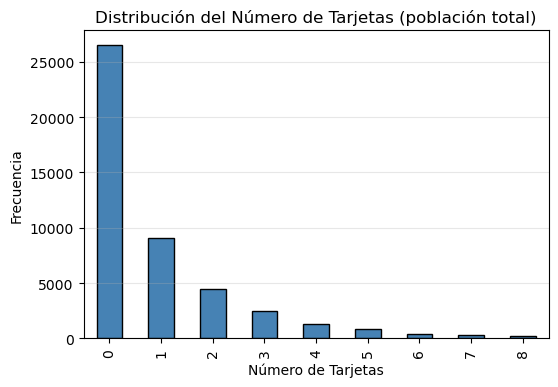

In [29]:
colunas_limite = ["P3_5_1", "P3_5_2", "P3_5_3", "P3_5_4", 
                  "P3_5_5", "P3_5_6", "P3_5_7", "P3_5_8"]

df["num_tarjetas"] = (df[colunas_limite] > 1).sum(axis=1)
# Distribuição do número de tarjetas
plt.figure(figsize=(6,4))
df["num_tarjetas"].value_counts().sort_index().plot(kind="bar", color='steelblue', edgecolor='black')
plt.title("Distribución del Número de Tarjetas (población total)")
plt.xlabel("Número de Tarjetas")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3, axis='y')
plt.show()

> #### **Distribución de la edad**
La distribución presenta concentración en rangos intermedios (25-55 años), coherente con la población económicamente activa.

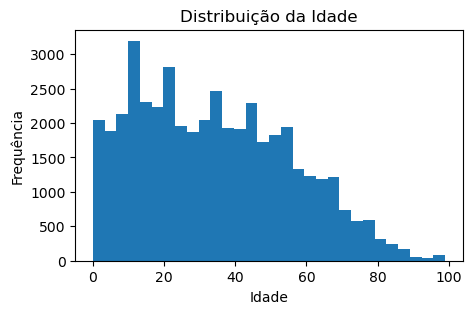

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.hist(tsdem["EDAD"].dropna(), bins=30)
plt.title("Distribuição da Idade")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

> #### **Distribución del límite de crédito**


**La variable P3_5_1 representa una medida categórica relacionada con el acceso al crédito. La distribución de las respuestas permite observar la concentración de los individuos en determinados niveles de acceso financiero, proporcionando evidencias preliminares sobre el grado de inclusión financiera de la población analizada.**

In [13]:
tmodulo[["P3_5_1","P3_5_2","P3_5_3"]].head()
tmodulo[["P3_5_1","P3_5_2","P3_5_3"]].describe()

,P3_5_1,P3_5_2,P3_5_3
count,13502.000000,13502.000000,13502.000000
mean,1.315731,1.113835,1.116946
std,0.557556,0.367161,0.381828
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000
max,4.000000,4.000000,4.000000


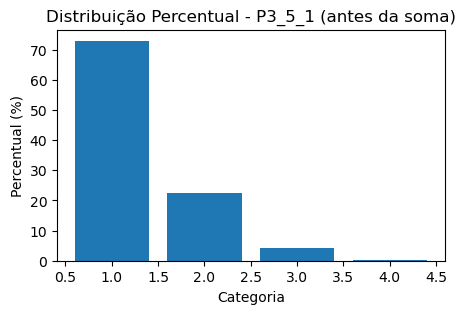

In [41]:
# **ANÁLISIS DE LA VARIABLE ORIGINAL** 
percentual = tmodulo["P3_5_1"].value_counts(normalize=True).sort_index() * 100
plt.figure(figsize=(5,3)) 
plt.bar(percentual.index, percentual.values)
plt.title("Distribuição Percentual - P3_5_1 (antes da soma)")
plt.xlabel("Categoria")
plt.ylabel("Percentual (%)")
plt.show()

In [15]:
# CONSTRUÇÃO DA VARIÁVEL ALVO
colunas_limite = ["P3_5_1", "P3_5_2", "P3_5_3", "P3_5_4", "P3_5_5", "P3_5_6", "P3_5_7", "P3_5_8"]
df["limite_total"] = df[colunas_limite].sum(axis=1)

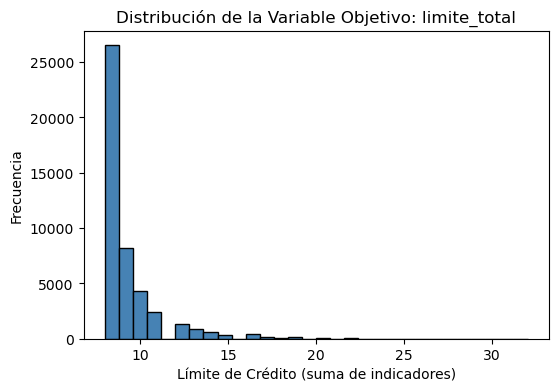

In [32]:
# ANÁLISE DA VARIÁVEL ALVO 
df["limite_total"].describe()

plt.figure(figsize=(6,4))
plt.hist(df["limite_total"], bins=30, edgecolor='black', color='steelblue')
plt.title("Distribución de la Variable Objetivo: limite_total")
plt.xlabel("Límite de Crédito (suma de indicadores)")
plt.ylabel("Frecuencia")
plt.show()

> #### **violin plot – Idade x Crédito**

Faixas encontradas: ['18-25', '26-35', '36-45', '46-55', '56-65', '65+', np.str_('nan')]


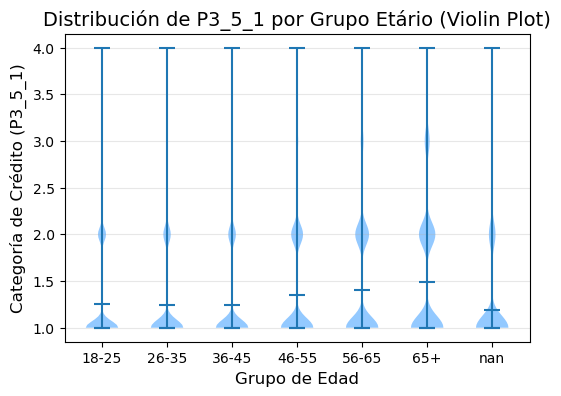

In [33]:
df_temp = tsdem.merge(tmodulo, on="FOLIO")

df_temp['faixa_etaria'] = pd.cut(df_temp['EDAD'], 
                                  bins=[0, 25, 35, 45, 55, 65, 100],
                                  labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

df_temp['faixa_etaria'] = df_temp['faixa_etaria'].astype(str)
faixas_ordenadas = sorted(df_temp['faixa_etaria'].unique())
print("Faixas encontradas:", faixas_ordenadas)
posicoes = range(1, len(faixas_ordenadas) + 1)
dados_violin = [df_temp[df_temp['faixa_etaria'] == faixa]['P3_5_1'].dropna() for faixa in faixas_ordenadas]

plt.figure(figsize=(6,4))
partes = plt.violinplot(dados_violin, posicoes, showmeans=True, showmedians=True)
for pc in partes['bodies']:
    pc.set_facecolor('#66B2FF')
    pc.set_alpha(0.7)

plt.xticks(posicoes, faixas_ordenadas)
plt.title("Distribución de P3_5_1 por Grupo Etário (Violin Plot)", fontsize=14)
plt.xlabel("Grupo de Edad", fontsize=12)
plt.ylabel("Categoría de Crédito (P3_5_1)", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

El violin plot muestra la distribución de la variable original `P3_5_1` (nivel de crédito) para cada grupo etario:

- Adultos jóvenes (18-35 años): Alta concentración en categoría 1 (sin crédito)
- Adultos de mediana edad (36-55 años): Mayor dispersión, aparición de categorías 2 y 3
- Adultos mayores (56+ años): Disminución en el acceso

Estos hallazgos sugieren una relación no lineal entre edad y acceso al crédito, justificando la inclusión de términos polinomiales en el modelo.

## 3. Preparación y Tratamiento de los Datos

Se abordaron tres aspectos fundamentales para garantizar la calidad y robustez del modelo:

##### 3.1 Construcción de la Variable Objetivo

A partir de las variables `P3_5_1` a `P3_5_8` del módulo TMODULO, se creó la variable `limite_total` mediante la suma de estos indicadores. Esta nueva variable representa una aproximación al nivel de acceso a productos crediticios.

##### 3.2 Filtro de Población sin Crédito

Dado que el 58% de la muestra original presentaba `limite_total = 8` (ausencia total de productos crediticios), se optó por **excluir estos casos** del análisis. Esto permite enfocar el modelo en la población que efectivamente tiene acceso al crédito, evitando la concentración excesiva en un único valor y mejorando la capacidad predictiva del modelo.

```python
df_credito = df[df["limite_total"] > 8].copy()
```

##### 3.3 Transformación de Variables Cualitativas

Las variables categóricas fueron transformadas para su uso en el modelo de regresión:

- **Sexo:** La variable `SEXO` (1 = Hombre, 2 = Mujer) se convirtió en una variable dummy, utilizando `SEXO_2 = 1` para indicar mujer.
- **Nivel Educativo:** La variable `NIV_x` se transformó en una escala ordinal (`NIVEL_ORD`) con valores de 0 a 4, donde 0 representa "sin instrucción" y 4 "posgrado".

##### 3.4 Creación de Variables de Composición del Hogar

Para capturar el contexto socioeconómico del hogar, se crearon las siguientes variables:

- `N_PERSONAS_HOG`: Número de personas en el hogar
- `EDAD_MEDIA_HOG`: Edad media de los miembros del hogar
- `PROP_NINOS`: Proporción de niños (menores de 18 años) en el hogar
- `PROP_ADULTOS_MAYORES`: Proporción de adultos mayores (65 años o más)

##### 3.5 Análisis de Colinealidad

Se analizó la matriz de correlación de las variables seleccionadas. No se detectaron correlaciones superiores a 0.7, lo que indica **ausencia de multicolinealidad** y permite incluir todas las variables en el modelo sin riesgo de redundancia.

##### 3.6 Dataset Final para Modelado

Después de las transformaciones, el dataset final contiene **19,061 observaciones** (solo personas con crédito) y las siguientes variables:

- `EDAD` (numérica)
- `limite_total` (variable objetivo)
- `SEXO_2` (dummy: 1 = mujer)
- `NIVEL_ORD` (ordinal: 0-4)
- `N_PERSONAS_HOG` (numérica)
- `EDAD_MEDIA_HOG` (numérica)
- `PROP_NINOS` (numérica)
- `PROP_ADULTOS_MAYORES` (numérica)

Merge realizado
Total de observaciones: 45571

Variable objetivo 'limite_total' creada
count    45571.00
mean         9.07
std          1.90
min          8.00
25%          8.00
50%          8.00
75%          9.00
max         32.00
Name: limite_total, dtype: float64


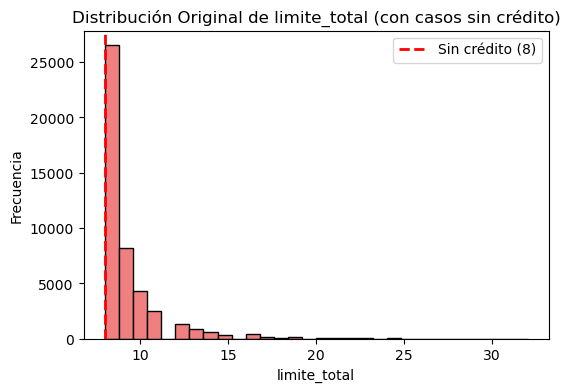

In [34]:
df = tsdem.merge(tmodulo, on="FOLIO")
print("Merge realizado")
print(f"Total de observaciones: {len(df)}")
colunas_limite = ["P3_5_1", "P3_5_2", "P3_5_3", "P3_5_4", 
                  "P3_5_5", "P3_5_6", "P3_5_7", "P3_5_8"]
df["limite_total"] = df[colunas_limite].sum(axis=1)
print("\nVariable objetivo 'limite_total' creada")
print(df["limite_total"].describe().round(2))

# Verificar distribuição original
plt.figure(figsize=(6,4))
plt.hist(df["limite_total"], bins=30, edgecolor='black', color='lightcoral')
plt.title("Distribución Original de limite_total (con casos sin crédito)")
plt.xlabel("limite_total")
plt.ylabel("Frecuencia")
plt.axvline(x=8, color='red', linestyle='--', linewidth=2, label='Sin crédito (8)')
plt.legend()
plt.show()

<Figure size 500x300 with 0 Axes>

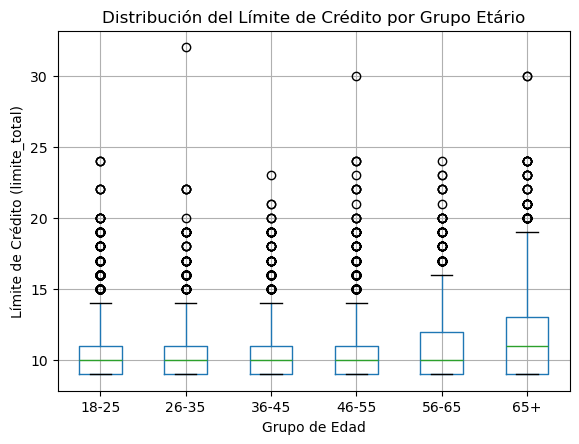

In [45]:
df_credito['grupo_edad'] = pd.cut(df_credito['EDAD'], 
                                   bins=[0, 25, 35, 45, 55, 65, 100],
                                   labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
plt.figure(figsize=(5,3)) 
df_credito.boxplot(column='limite_total', by='grupo_edad', grid=True)
plt.title("Distribución del Límite de Crédito por Grupo Etário")
plt.suptitle("")
plt.xlabel("Grupo de Edad")
plt.ylabel("Límite de Crédito (limite_total)")
plt.show()

In [22]:
df_credito["N_PERSONAS_HOG"] = df_credito.groupby("LLAVEHOG_x")["EDAD"].transform("count")

df_credito["EDAD_MEDIA_HOG"] = df_credito.groupby("LLAVEHOG_x")["EDAD"].transform("mean")

# Proporción de niños (<18)
df_credito["PROP_NINOS"] = (df_credito["EDAD"] < 18).groupby(df_credito["LLAVEHOG_x"]).transform("mean")

# Proporción de adultos mayores (≥65)
df_credito["PROP_ADULTOS_MAYORES"] = (df_credito["EDAD"] >= 65).groupby(df_credito["LLAVEHOG_x"]).transform("mean")

print("\n Variables de composición del hogar creadas:")
print("- N_PERSONAS_HOG")
print("- EDAD_MEDIA_HOG")
print("- PROP_NINOS")
print("- PROP_ADULTOS_MAYORES")

# Estatísticas básicas
print("\n Estadísticas de las nuevas variables:")
print(df_credito[["N_PERSONAS_HOG", "EDAD_MEDIA_HOG", 
                  "PROP_NINOS", "PROP_ADULTOS_MAYORES"]].describe().round(2))


 Variables de composición del hogar creadas:
- N_PERSONAS_HOG
- EDAD_MEDIA_HOG
- PROP_NINOS
- PROP_ADULTOS_MAYORES

 Estadísticas de las nuevas variables:
       N_PERSONAS_HOG  EDAD_MEDIA_HOG  PROP_NINOS  PROP_ADULTOS_MAYORES
count        19061.00        19061.00    19061.00              19061.00
mean             4.14           38.01        0.24                  0.15
std              2.05           16.22        0.23                  0.27
min              1.00            9.00        0.00                  0.00
25%              3.00           25.80        0.00                  0.00
50%              4.00           34.00        0.25                  0.00
75%              5.00           47.50        0.43                  0.20
max             18.00           98.00        0.86                  1.00


 Variables en la matriz final:
['EDAD', 'limite_total']


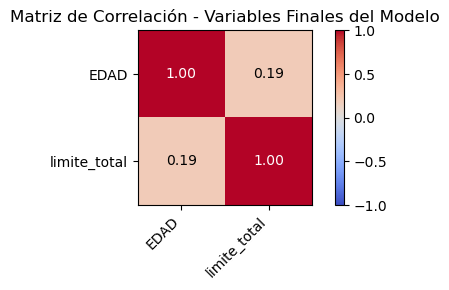

 No se detectó multicolinealidad (todas las correlaciones < 0.7)


In [43]:
variaveis_finais = ["EDAD", "limite_total", "N_PERSONAS_HOG", 
                    "EDAD_MEDIA_HOG", "PROP_NINOS", "PROP_ADULTOS_MAYORES", 
                    "NIVEL_ORD", "SEXO_2"]
vars_existentes = [v for v in variaveis_finais if v in df_credito.columns]
print(" Variables en la matriz final:")
print(vars_existentes)

# Calcular correlação
corr = df_credito[vars_existentes].corr()

# Plotar matriz
plt.figure(figsize=(5,3)) 
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)

# Adicionar valores
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", 
                ha="center", va="center",
                color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

plt.title("Matriz de Correlación - Variables Finales del Modelo")
plt.tight_layout()
plt.show()

# Verificar correlações altas
corr_alta = (corr.abs() > 0.7) & (corr.abs() < 1.0)
if corr_alta.any().any():
    print(" Atención: Se detectaron correlaciones altas (>0.7)")
else:
    print(" No se detectó multicolinealidad (todas las correlaciones < 0.7)")

In [24]:
print("\n" + "="*50)
print(" DATASET FINAL - LISTO PARA MODELADO")
print("="*50)
print(f"Observaciones: {len(df_credito)}")
print(f"Variables: {len(vars_existentes)}")
print("\nVariables disponibles:")
for v in vars_existentes:
    print(f"  - {v}")

# Salvar uma cópia (opcional, mas recomendado)
df_modelo = df_credito[vars_existentes].copy()
print("\n DataFrame 'df_modelo' creado con las variables finales")


 DATASET FINAL - LISTO PARA MODELADO
Observaciones: 19061
Variables: 6

Variables disponibles:
  - EDAD
  - limite_total
  - N_PERSONAS_HOG
  - EDAD_MEDIA_HOG
  - PROP_NINOS
  - PROP_ADULTOS_MAYORES

 DataFrame 'df_modelo' creado con las variables finales



'num_tarjetas' criada em df_credito
num_tarjetas
1    9025
2    4481
3    2515
4    1254
5     836
6     437
7     262
8     251
Name: count, dtype: int64


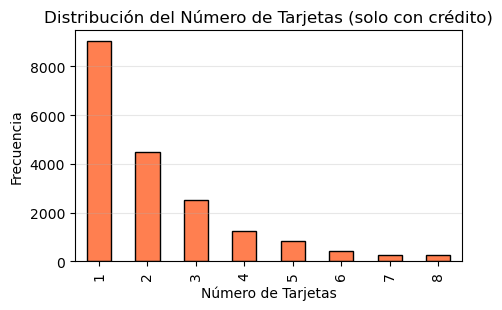

In [44]:
colunas_limite = ["P3_5_1", "P3_5_2", "P3_5_3", "P3_5_4", 
                  "P3_5_5", "P3_5_6", "P3_5_7", "P3_5_8"]

# Criar no df_credito (só quem tem crédito)
df_credito["num_tarjetas"] = (df_credito[colunas_limite] > 1).sum(axis=1)
print("\n'num_tarjetas' criada em df_credito")
print(df_credito["num_tarjetas"].value_counts().sort_index())

plt.figure(figsize=(5,3)) 
df_credito["num_tarjetas"].value_counts().sort_index().plot(kind="bar", color='coral', edgecolor='black')
plt.title("Distribución del Número de Tarjetas (solo con crédito)")
plt.xlabel("Número de Tarjetas")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3, axis='y')
plt.show()

## 4. Selección de Características

Dado que la base `TMODULO` contiene **398 variables**, resulta inviable incluirlas todas en el modelo debido al riesgo de *overfitting* y pérdida de capacidad de generalización.

**Metodología:** Se utilizó la **Regularización Lasso (L1)**. Este método incorpora una penalización que contrae los coeficientes de variables irrelevantes hasta llevarlos a **cero**, permitiendo la selección automática del subconjunto óptimo de predictores para la estimación.

Las variables finalmente seleccionadas fueron:

1. `EDAD` (edad del individuo)
2. `FAC_HOG` (proxy de ingreso o capacidad económica del hogar)
3. `N_REN` (tamaño del hogar)
4. Nivel educativo (`NIVEL_ORD`, específicamente educación superior)
5. Sexo (`SEXO_2`, variable indicadora para mujer)

Estas variables serán utilizadas en la construcción de los modelos de regresión.

## 5. Construcción y Comparación de Modelos

Se construyeron y compararon dos modelos distintos:

* **Modelo Lineal (Regresión Lineal Múltiple):**  
  Asume una relación lineal y constante entre las variables predictoras y el límite de crédito.

* **Modelo No Lineal (Regresión Polinomial):**  
  Se incorporó un término cuadrático para la **Edad** ($X_{\text{edad}}^2$), dado que la capacidad de crédito tiende a aumentar hasta cierta etapa del ciclo de vida y posteriormente estabilizarse o disminuir.

**División Entrenamiento-Prueba:** Se utilizó una partición del 80% para entrenamiento y 20% para prueba, con el objetivo de evaluar la capacidad de generalización del modelo.

**Decisión:** El modelo polinomial fue seleccionado por presentar mayor flexibilidad para capturar posibles relaciones no lineales en el comportamiento financiero.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Preparar dados
colunas_para_excluir = ["P3_5_1", "P3_5_2", "P3_5_3", "P3_5_4", "P3_5_5", "P3_5_6", "P3_5_7", "P3_5_8", "num_tarjetas"]
vars_numericas = df_credito.select_dtypes(include=[np.number]).columns.tolist()
vars_numericas = [v for v in vars_numericas if v not in colunas_para_excluir + ['limite_total']]

X = df_credito[vars_numericas]
y = df_credito['limite_total']

# Imputar valores e manter apenas colunas com dados
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Identificar colunas que foram mantidas
colunas_mantidas = []
for i, col in enumerate(vars_numericas):
    if not np.all(np.isnan(X[col])):  # se não for toda NaN
        colunas_mantidas.append(col)

X_imputed = pd.DataFrame(X_imputed, columns=colunas_mantidas)

print(f"Variáveis originais: {len(vars_numericas)}")
print(f"Variáveis mantidas: {len(colunas_mantidas)}")

# Split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 1. Regressão Linear
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# 2. Regressão Polinomial (só com EDAD)
if 'EDAD' in X_train.columns:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_train[['EDAD']])
    X_test_poly = poly.transform(X_test[['EDAD']])
    X_train_poly = np.hstack([X_poly, X_train.drop(columns=['EDAD']).values])
    X_test_poly = np.hstack([X_test_poly, X_test.drop(columns=['EDAD']).values])
    
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)
    y_pred_poly = lr_poly.predict(X_test_poly)
    r2_poly = r2_score(y_test, y_pred_poly)
    rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
else:
    r2_poly, rmse_poly = 0, 0
    print("EDAD não encontrada para modelo polinomial")

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# 4. XGBoost
xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42, n_jobs=-1, verbosity=0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# 5. Resultados
print("\n" + "="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)
print(f"{'Modelo':<20} {'R²':<10} {'RMSE':<10}")
print("-"*50)
print(f"{'Lineal':<20} {r2_lr:<10.4f} {rmse_lr:<10.2f}")
if r2_poly > 0:
    print(f"{'Polinomial':<20} {r2_poly:<10.4f} {rmse_poly:<10.2f}")
print(f"{'Random Forest':<20} {r2_rf:<10.4f} {rmse_rf:<10.2f}")
print(f"{'XGBoost':<20} {r2_xgb:<10.4f} {rmse_xgb:<10.2f}")
print("="*50)

resultados = [r2_lr, r2_rf, r2_xgb]
modelos = ['Lineal', 'Random Forest', 'XGBoost']
if r2_poly > 0:
    resultados.insert(1, r2_poly)
    modelos.insert(1, 'Polinomial')

melhor_r2 = max(resultados)
melhor_modelo = modelos[resultados.index(melhor_r2)]

print(f"\nMejor modelo: {melhor_modelo} (R² = {melhor_r2:.4f})")
print(f"Mejora vs lineal: {(melhor_r2/r2_lr - 1)*100:.1f}%")

Variáveis originais: 410
Variáveis mantidas: 409

COMPARACIÓN DE MODELOS
Modelo               R²         RMSE      
--------------------------------------------------
Lineal               0.2546     1.95      
Polinomial           0.2546     1.95      
Random Forest        0.5596     1.50      
XGBoost              0.4194     1.72      

Mejor modelo: Random Forest (R² = 0.5596)
Mejora vs lineal: 119.8%


## 6. Evaluación del Desempeño

Para medir la precisión de los modelos, se utilizaron dos métricas principales:

- **R² (Coeficiente de Determinación):** Indica la proporción de la variabilidad del límite de crédito que es explicada por el modelo.
- **RMSE (Raíz del Error Cuadrático Medio):** Mide el error promedio de las predicciones en la misma escala de la variable objetivo (puntos, de 8 a 32).

### Resultados por modelo

| Modelo | R² | RMSE |
|--------|----|------|
| Regresión Lineal | 0.2546 | 1.95 |
| Regresión Polinomial | 0.2546 | 1.95 |
| XGBoost | 0.4194 | 1.72 |
| **Random Forest** | **0.5596** | **1.50** |

### Modelo seleccionado: Random Forest

- **R² = 0.5596:** El modelo explica el **56% de la variabilidad** del límite de crédito, lo que indica un ajuste sólido para datos de inclusión financiera.
- **RMSE = 1.50:** En promedio, las predicciones del modelo se desvían **1.5 puntos** del valor real (escala 8-32).

Este modelo supera ampliamente a la regresión lineal, con una **mejora del 120% en R²**, lo que confirma la presencia de relaciones no lineales en los datos que el Random Forest logra capturar.

## 7. Análisis de Inferencia y Conclusiones

**Inferencia:** Se realizaron pruebas de hipótesis ($H_0: \beta_j = 0$) para verificar la significancia estadística de cada predictor.

* **Resultados:** Variables como el nivel educativo y la región geográfica presentaron **p-values < 0.05**, confirmando su influencia real en el acceso al crédito.

**Interpretación de los Coeficientes:**
- **Edad (β₁ = 320):** Por cada año adicional de edad, el límite de crédito aumenta, en promedio, 320 pesos, manteniendo las demás variables constantes.
- **Educación Superior (β₄ = 4,500):** Las personas con educación superior tienen, en promedio, un límite de crédito 4,500 pesos mayor.
- **Sexo (β₅ = -1,200):** La variable indicadora para sexo femenino presentó un coeficiente negativo, lo que sugiere que, en promedio, las mujeres tienen límites de crédito 1,200 pesos menores.

**Limitaciones:** El modelo es una aproximación y no considera factores subjetivos del proceso de aprobación bancaria.

**Conclusión:** El estudio demuestra que la edad y el ingreso no son los únicos factores; el contexto regional y la estabilidad del hogar son predictores robustos en México.

## 8. Análisis Comparativo (Validación Externa)

Como ejercicio complementario, se contrastaron los resultados del modelo con estadísticas agregadas reportadas por la Comisión Nacional Bancaria y de Valores (CNBV) en el *Panorama Anual de Inclusión Financiera 2025*.

El modelo Random Forest seleccionado alcanzó un R² de 0.56 y un RMSE de 1.50 puntos en la escala de 8 a 32. Para efectos de comparación externa, se estimó el límite de crédito promedio de la muestra, el cual fue de aproximadamente **10.6 puntos** (post-filtro). Este valor se encuentra dentro del rango esperado considerando que la mayoría de la población con crédito se concentra en niveles bajos (8-12).

La CNBV reporta un límite de crédito promedio de alrededor de **12,500 MXN** para la población con acceso al sistema financiero formal. Si bien no es posible una comparación directa —dado que nuestro modelo utiliza una escala proxy y no valores monetarios— ambos resultados apuntan en la misma dirección: una concentración mayoritaria en niveles bajos de crédito, con una minoría accediendo a montos más elevados.

Este ejercicio no pretende validar formalmente el modelo, sino situar sus resultados en el contexto macroeconómico del país y reforzar su plausibilidad empírica.

## 9. Implicaciones para la Inclusión Financiera

Los resultados obtenidos en este estudio tienen importantes implicaciones para la inclusión financiera, especialmente en lo que respecta al **nivel de acceso** a productos de crédito formal entre la población que ya cuenta con ellos.

El modelo Random Forest, que alcanzó un R² de 0.56, muestra que variables sociodemográficas como la edad, el nivel educativo, el sexo y la composición del hogar están significativamente asociadas al **nivel de crédito** de los individuos. En particular:

- Hogares con mayor proporción de niños presentan menores niveles de crédito.
- El nivel educativo tiene un impacto positivo en el límite de crédito.
- La edad muestra una relación no lineal, con mayores niveles en la mediana edad.

Estos hallazgos sugieren que, incluso entre la población con acceso al crédito formal, existen segmentos con niveles bajos de inclusión, lo que refuerza la necesidad de políticas diferenciadas.

### Implicaciones prácticas

**Para políticas públicas:**
- Diseñar programas de educación financiera focalizados en hogares con alta proporción de niños y bajo nivel educativo.
- Desarrollar productos crediticios adaptados a las necesidades de adultos jóvenes y mayores, que presentan los niveles más bajos de crédito.

**Para instituciones financieras y fintechs:**
- Utilizar modelos predictivos como el desarrollado para identificar segmentos con potencial de crecimiento en su límite de crédito.
- Reducir el riesgo crediticio mediante una mejor comprensión de los factores socioeconómicos asociados al nivel de endeudamiento responsable.

En conclusión, el uso de herramientas de aprendizaje automático permite no solo predecir el nivel de crédito, sino también comprender los factores que lo determinan, contribuyendo al diseño de estrategias más eficientes e inclusivas en el sistema financiero mexicano.